In [1]:
#libraries

import requests
from io import BytesIO
import json
import time
import zipfile
import os
import pickle
import sys
from pathlib import Path
import subprocess
import sys
import importlib

In [2]:
# Install libraries if they are not installed
required_packages = {
     "pandas": "pandas",
    "matplotlib": "matplotlib",
    "Pillow": "PIL",  
    "minio": "minio",
    "shutil":"shutil"
}
for pip_name, import_name in required_packages.items():
    try:
        importlib.import_module(import_name)
        print(f"'{pip_name}' is already installed.")
    except ImportError:
        print(f"Installing '{pip_name}'...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name])
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from minio import Minio
import shutil

✅ 'pandas' ya está instalado.
✅ 'matplotlib' ya está instalado.
✅ 'Pillow' ya está instalado.
✅ 'minio' ya está instalado.
✅ 'shutil' ya está instalado.


In [3]:
def get_latest_zip_object():
    # Gets the latest ZIP from the bucket
    objects = client.list_objects(bucket_name, prefix=prefix, recursive=True)
    zip_objects = [obj for obj in objects if obj.object_name.endswith('.zip')]
    if not zip_objects:
        return None
   # Sort by modification date (descending)
    zip_objects.sort(key=lambda x: x.last_modified, reverse=True)
    return zip_objects[0]

def process_zip(zip_path, output):
   #Extracts and processes the contents of the ZIP and saves the results to output/<zip_name>/
    zip_name = os.path.splitext(os.path.basename(zip_path))[0]
    output_dir = os.path.join(output, zip_name)
    os.makedirs(output_dir, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)
    json_files = []
    image_files = []
    for root, _, files in os.walk(output_dir):
        for file in files:
            path = os.path.join(root, file)
            if file.endswith('.json'):
                json_files.append(path)
            elif file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_files.append(path)
    if image_files:
        print(f"Images found: {image_files}")
        for img_path in image_files:
            img = Image.open(img_path)
            plt.figure()
            plt.imshow(img)
            plt.axis('off')
            plt.title(os.path.basename(img_path))
        plt.show()
    else:
        print("No images found.")
    if json_files:
        print(f"JSON Files found: {json_files}")
        for json_path in json_files:
            with open(json_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            print(f"Content of {os.path.basename(json_path)}:")
            print(json.dumps(data, indent=4, ensure_ascii=False))
    else:
        print("No JSON file found.")
    print(f"Results saved in: {output_dir}")

In [4]:
minio_credencials= os.getenv("MINIO_CREDENCIALS","minio_body.pkl")
if not minio_credencials.endswith(".pkl"):
    minio_credencials += ".pkl"
# Load configuration from .pkl file
with open(minio_credencials, "rb") as f:
    config = pickle.load(f)
# Create MinIO client
client = Minio(
    endpoint=config["endpoint"],
    access_key=config["access_key"],
    secret_key=config["secret_key"],
    secure= True
)
print("MinIO client loaded from configuration.")

MinIO client loaded from configuration.


In [5]:
#Necessary environment variables

bucket_name= os.getenv("BUCKET_NAME","")
out= os.getenv("PREFIX","")
prefix=out+"/"
output= os.getenv("OUTPUT",'output')
download_dir = './temporal'  # Local folder where to save the file

Waiting for new .zip file in body-pose-test/out/...
File Detected: out/2025-07-18 12:05:22-872212.zip
Saved in: ./temporal/2025-07-18 12:05:22-872212.zip
Images found: ['output/2025-07-18 12:05:22-872212/body.png']


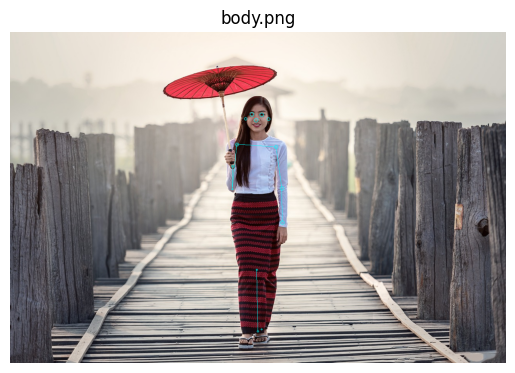

JSON Files found: ['output/2025-07-18 12:05:22-872212/output.json']
Content of output.json:
[
    {
        "img_path": "/tmp/2025-07-18 12:05:22-872212/body.png",
        "nose": {
            "coordinate_x": 229.24093069962817,
            "coordinate_y": 634.6577009309743,
            "score": 0.9981870651245117
        },
        "leftEye": {
            "coordinate_x": 215.44448158345037,
            "coordinate_y": 649.1535657872267,
            "score": 0.998451828956604
        },
        "rightEye": {
            "coordinate_x": 214.3730446138146,
            "coordinate_y": 623.7662048399402,
            "score": 0.9962864518165588
        },
        "leftEar": {
            "coordinate_x": 226.50857249544705,
            "coordinate_y": 666.8329796057767,
            "score": 0.7789555788040161
        },
        "rightEar": {
            "coordinate_x": 225.72308680825859,
            "coordinate_y": 607.711518263091,
            "score": 0.6793251037597656
        },
     

In [6]:
# Inicial State
print(f"Waiting for new .zip file in {bucket_name}/{prefix}...")
initial_obj = get_latest_zip_object()
last_seen_key = initial_obj.object_name if initial_obj else None
last_seen_time = initial_obj.last_modified if initial_obj else None
#Actively wait until new or modified file is detected
while True:
    latest_obj = get_latest_zip_object()
    if latest_obj:
        new_key = latest_obj.object_name
        new_time = latest_obj.last_modified

        if new_key != last_seen_key or new_time != last_seen_time:
            print(f"File Detected: {new_key}")
            local_zip_path = os.path.join(download_dir, os.path.basename(new_key))
            client.fget_object(bucket_name, new_key, local_zip_path)
            print(f"Saved in: {local_zip_path}")
            process_zip(local_zip_path,output)
            break  # Terminate after processing
    time.sleep(5)